In [1]:
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.utils
import sklearn.model_selection
import sklearn.metrics
import pandas as pd

In [2]:
sys.path.insert(0, "..")

In [3]:
from hmm import GaussianVariationalMHMM, HMMCluster, GaussianMHMM, plots
from hmm import GaussianHMM, GaussianVariationalHMM
from hmm.datasets import synthetic, for_tests

In [4]:
random_state = sklearn.utils.check_random_state(None)

## Dataset from Smyth
Use a dataset from Padraich Smyth ~1997 on Clustering with HMMs.  Clusters sequences generated from 2-state HMMS with identical Gaussian emissions but differing transition probabilities.  He trains on 20 sequences of length 200 from each model.

The gaussians have variance of 1 and are centered at 0 and 3.

The transition matrices are:

```
    [[ .4, .6], 
    [.6, .4]]
```

and 

``` 
    [[.6, .4], 
    [.4, .6]]```

In [5]:
model1, model2 = synthetic.get_smyth_clustering_models(random_state=random_state)

In [6]:
train_size = .5
train_number = 20
n_samples = int(train_number / train_size )
model1_samples = model1.sample(n_samples, 200)[0]
model2_samples = model2.sample(n_samples, 200)[0]

In [7]:
all_samples_smyth = np.concatenate([model1_samples, model2_samples])

labels_smyth = np.asarray([0] * n_samples + [1] * n_samples)
all_samples_smyth.shape

(80, 200)

In [8]:
n_inits = 10
n_jobs = 4
n_components = 3
n_mixture_components = 3
n_iterations = 1000

In [9]:
variational_mixture = GaussianVariationalMHMM.GaussianVariationalMHMM(
    n_mixture_components=n_mixture_components,
    n_components=n_components,
    n_iterations=n_iterations,
    n_inits=n_inits,
    n_jobs=-1
)
em_mixtures = GaussianMHMM.GaussianMHMM(
    n_mixture_components=n_mixture_components,
    n_components=n_components,
    n_iterations=n_iterations,
    n_inits=n_inits,
    n_jobs=-1
)


In [10]:
train_data_smyth, test_data_smyth, train_labels_smyth, test_labels_smyth = sklearn.model_selection.train_test_split(
    all_samples_smyth, labels_smyth, test_size=.5, stratify=labels_smyth)

In [11]:
sum(train_labels_smyth)

20

In [12]:
train_data_smyth.shape

(40, 200)

## EM Mixture of HMMS 

In [13]:
em_mixtures.fit(train_data_smyth)

GaussianMHMM(allowed_to_use_log=True, implementation='scaling',
       init_A='random', init_emissions='kmeans',
       init_mixture_weights='uniform', init_pi='random', n_components=3,
       n_inits=10, n_iterations=1000, n_jobs=-1, n_mixture_components=3,
       random_state=None, tol=1e-06, variance_regularization=1e-06,
       verbose=0)

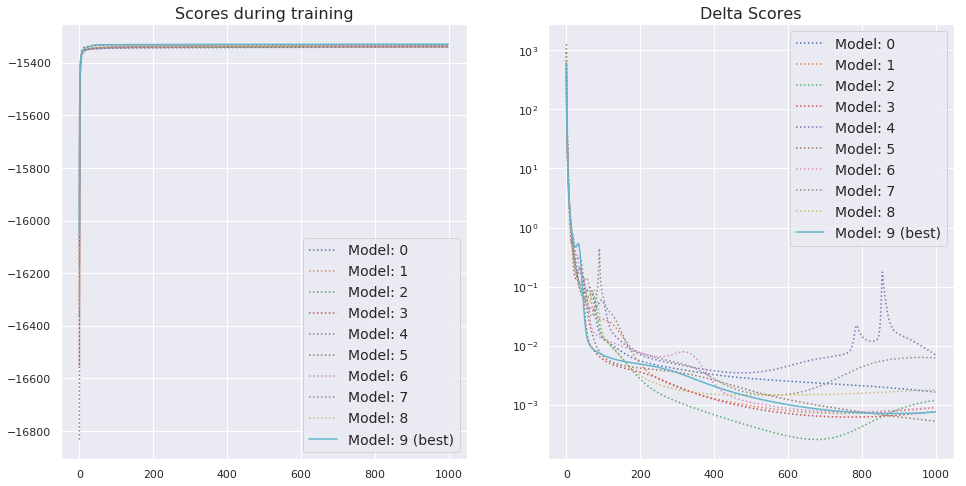

In [14]:
_ = plots.multiple_learning_plot(em_mixtures.explored_loglikelihoods_)

0    0.351865
1    0.497871
2    0.150263
dtype: float64


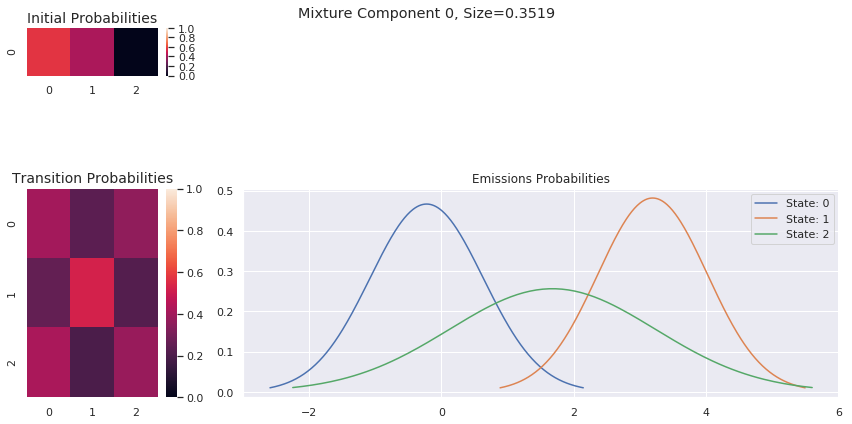

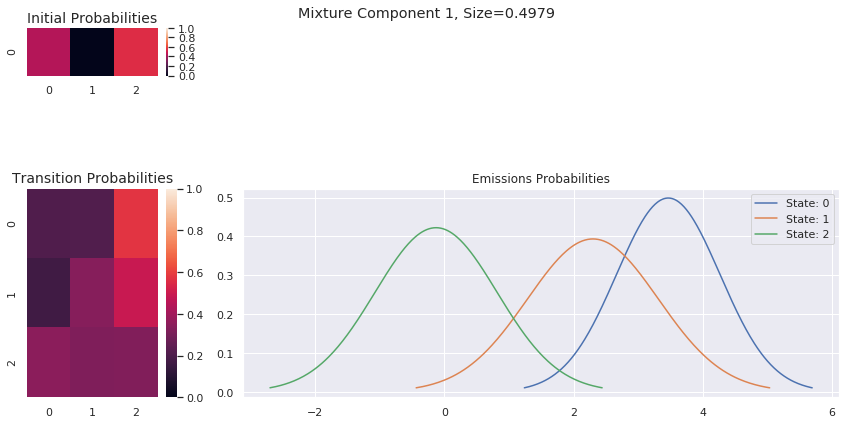

In [15]:
print(pd.Series(em_mixtures.mixture_weights_))
for mixture_component in range(em_mixtures.n_mixture_components):
    fig = plots.gaussian_hinton_diagram(
    em_mixtures.pi_[mixture_component],
    em_mixtures.A_[mixture_component],
    em_mixtures.means_[mixture_component],
    em_mixtures.variances_[mixture_component],
    vmin=0,
    vmax=1)
    
    fig.suptitle("Mixture Component {}, Size={:.4f}".format(mixture_component, em_mixtures.mixture_weights_[mixture_component]))

In [16]:
em_predicted_smyth = em_mixtures.predict(test_data_smyth)
pd.crosstab(test_labels_smyth, em_predicted_smyth)

0
1
2


col_0   0   1  2
row_0           
0      17   0  3
1       1  19  0

In [17]:
HMMCluster.cluster_report(test_labels_smyth, em_predicted_smyth)

Mutual Info	0.597
Norm Mutual Info	0.752
Rand Score	0.776
Completeness	0.658
V-Measure	0.746


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


## Variational Mixture of HMMS

In [18]:
%time variational_mixture.fit(train_data_smyth)

CPU times: user 31.7 ms, sys: 4.29 ms, total: 35.9 ms
Wall time: 1min 1s


GaussianVariationalMHMM(A_prior=None, allowed_to_use_log=True,
            implementation='scaling', init_mixture_weights=None,
            means_prior='uninformed', mixture_weights_prior=None,
            n_components=3, n_inits=10, n_iterations=1000, n_jobs=-1,
            n_mixture_components=3, pi_prior=None, random_state=None,
            tol=1e-06, variances_prior='uninformed', verbose=0)

In [19]:
variational_mixture.free_energy_[-1]

-8086.086044868833

In [20]:
_ = plots.multiple_learning_plot(variational_mixture.explored_free_energies_)

0    20.757061
1    19.909606
2     0.333333
dtype: float64


No handles with labels found to put in legend.


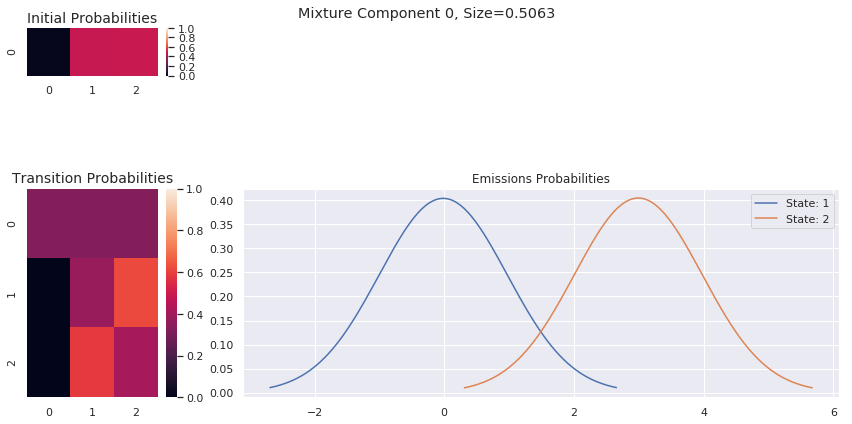

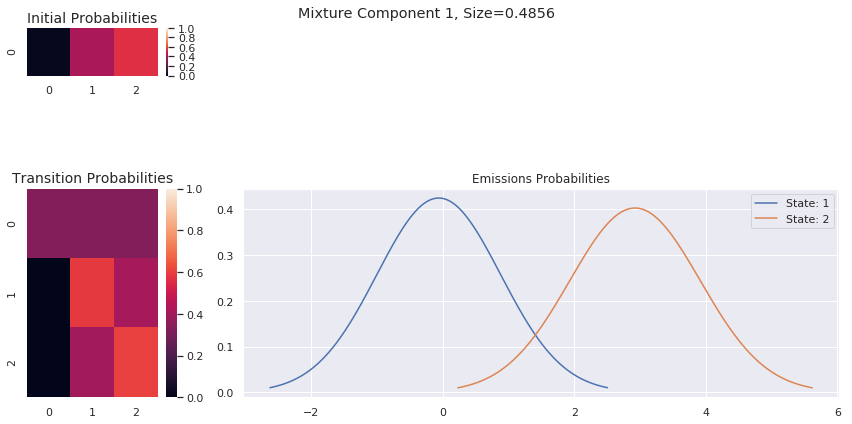

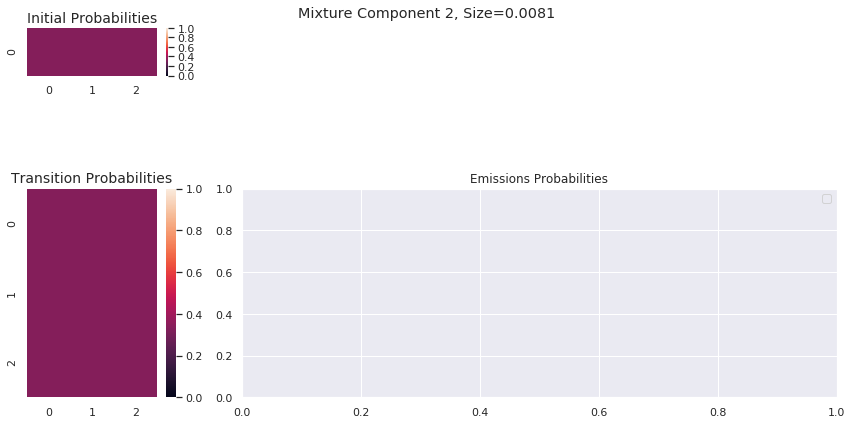

In [21]:
print(pd.Series(variational_mixture.mixture_weights_posterior_))
for mixture_component in range(variational_mixture.n_mixture_components):
    fig = plots.gaussian_hinton_diagram(
    variational_mixture.pi_normalized_[mixture_component],
    variational_mixture.A_normalized_[mixture_component],
    variational_mixture.means_posterior_[mixture_component],
    variational_mixture.variances_posterior_[mixture_component],
        vmin=0,
    vmax=1,
    )
    
    fig.suptitle("Mixture Component {}, Size={:.4f}".format(mixture_component, variational_mixture.mixture_weights_normalized_[mixture_component]))

In [22]:
vb_predicted = variational_mixture.predict(test_data_smyth)
pd.crosstab(test_labels_smyth, vb_predicted)

col_0   0   1
row_0        
0       0  20
1      19   1

In [23]:
HMMCluster.cluster_report(test_labels_smyth, vb_predicted)

Mutual Info	0.593
Norm Mutual Info	0.856
Rand Score	0.900
Completeness	0.857
V-Measure	0.856


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [24]:
variational_mixture.score(train_data_smyth)

-66783.55299841127

In [25]:
[e[-1] for e in variational_mixture.explored_free_energies_]

[-8120.9151026654245,
 -8096.258215921109,
 -8115.075055200224,
 -8091.471027011916,
 -8096.319902183295,
 -8118.8626736140895,
 -8091.411665150447,
 -8086.086044868833,
 -8091.414987122383,
 -8091.596745416299]

In [ ]:
variational_mixture.verbose_free_energy_[-1]

## Distance based clustering using EM

In [ ]:
emcluster2_2 = HMMCluster.HMMDistanceCluster(n_clusters=2, hmm_impl=GaussianHMM.GaussianHMM(n_components=2, n_inits=4))
emcluster2_3 = HMMCluster.HMMDistanceCluster(n_clusters=2, hmm_impl=GaussianHMM.GaussianHMM(n_components=3, n_inits=4))
emcluster3_2 = HMMCluster.HMMDistanceCluster(n_clusters=3, hmm_impl=GaussianHMM.GaussianHMM(n_components=2, n_inits=4))
emcluster3_3 = HMMCluster.HMMDistanceCluster(n_clusters=3, hmm_impl=GaussianHMM.GaussianHMM(n_components=3, n_inits=4))

In [ ]:
emcluster2_2.fit(train_data_smyth)
emcluster2_3.fit(train_data_smyth)
emcluster3_2.fit(train_data_smyth)
emcluster3_3.fit(train_data_smyth)

In [ ]:
def plot_emclustering(model, test_data, test_labels):
    fractions =model.assignment_fractions_
    for i, m in model.grouped_models_.items():
        fig = plots.gaussian_hinton_diagram(
            m.pi_,
            m.A_,
            m.means_,
            m.variances_,
            vmin=0,
            vmax=1
        )
        
        fig.suptitle("Mixture Component {}, Size={:.4f}".format(i, fractions[i]))
    predicted = model.predict(test_data)
    print(pd.crosstab(test_labels, predicted))
    HMMCluster.cluster_report(test_labels, predicted)

## 2 hmms, 2 components

In [ ]:
plot_emclustering(emcluster2_2, test_data_smyth, test_labels_smyth)

## 2 hmms, 3 components

In [ ]:
plot_emclustering(emcluster2_3, test_data_smyth, test_labels_smyth)

## 3 HMMS, 2 components

In [ ]:
plot_emclustering(emcluster3_2, test_data_smyth, test_labels_smyth)

## 3 HMMS, 3 Components

In [ ]:
plot_emclustering(emcluster3_3, test_data_smyth, test_labels_smyth)

## Distance based Clustering using VB

In [ ]:
vbcluster2_2 = HMMCluster.HMMDistanceCluster(n_clusters=2, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=2, n_inits=4))
vbcluster2_3 = HMMCluster.HMMDistanceCluster(n_clusters=2, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=3, n_inits=4))
vbcluster3_2 = HMMCluster.HMMDistanceCluster(n_clusters=3, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=2, n_inits=4))
vbcluster3_3 = HMMCluster.HMMDistanceCluster(n_clusters=3, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=3, n_inits=4))

In [ ]:
vbcluster2_2.fit(train_data_smyth)
vbcluster2_3.fit(train_data_smyth)
vbcluster3_2.fit(train_data_smyth)
vbcluster3_3.fit(train_data_smyth)

In [ ]:
def plot_vbclustering(model, test_data, test_labels):
    fractions =model.assignment_fractions_
    for i, m in model.grouped_models_.items():
        fig = plots.gaussian_hinton_diagram(
            m.pi_normalized_,
            m.A_normalized_,
            m.means_posterior_,
            m.variances_posterior_,
            vmin=0,
            vmax=1
        )
        
        fig.suptitle("Mixture Component {}, Size={:.4f}".format(i, fractions[i]))
    predicted = model.predict(test_data)
    print(pd.crosstab(test_labels, predicted))
    HMMCluster.cluster_report(test_labels, predicted)


## 2 HMMs, 2 Components

In [ ]:
plot_vbclustering(vbcluster2_2, test_data_smyth, test_labels_smyth)


## 2 HMMs, 3 Components

In [ ]:
plot_vbclustering(vbcluster2_3, test_data_smyth, test_labels_smyth)


## 3 HMMS 2 components


In [ ]:
plot_vbclustering(vbcluster3_2, test_data_smyth, test_labels_smyth)

## 3 HMMs 3 Components

In [ ]:
plot_vbclustering(vbcluster3_3, test_data_smyth, test_labels_smyth)

# A More complex model

In [ ]:
models = for_tests.get_perturbed_mcgrory_and_titterington(random_state)

In [ ]:
for i, m in enumerate(models):
    fig = plots.gaussian_hinton_diagram(
    m.pi_,
    m.A_,
    m.means_,
    m.variances_,
    vmin=0,
    vmax=1)
    fig.suptitle("Cluster {}".format(i))


In [ ]:
all_data4 = []
labels4 = []
n_samples = 40

for i, m in enumerate(models):
    all_data4.append(m.sample(n_samples, 500)[0])
    labels4.extend([i] * n_samples)

In [ ]:
all_data4 = np.concatenate(all_data4)
labels4 = np.asarray(labels4)

In [ ]:

train_data4, test_data4, train_labels4, test_labels4 = sklearn.model_selection.train_test_split(
    all_data4, labels4, test_size=.5, stratify=labels4)

In [ ]:
pd.Series(train_labels4).value_counts()

In [ ]:
n_mixture_components = 5
n_components = 5
n_iterations = 1000
n_inits = 4

In [ ]:

em_mixtures4 = GaussianMHMM.GaussianMHMM(
    n_mixture_components=n_mixture_components,
    n_components=n_components,
    n_iterations=n_iterations,
    n_inits=n_inits,
    n_jobs=-1
)


In [ ]:
em_mixtures4.fit(train_data4)

In [ ]:
em_mixtures4.pi_

In [ ]:
em_predicted4 = em_mixtures4.predict(test_data4)
pd.crosstab(test_labels4, em_predicted4)

In [ ]:
print(pd.Series(em_mixtures4.mixture_weights_))
for mixture_component in range(em_mixtures4.n_mixture_components):
    fig = plots.gaussian_hinton_diagram(
    em_mixtures4.pi_[mixture_component],
    em_mixtures4.A_[mixture_component],
    em_mixtures4.means_[mixture_component],
    em_mixtures4.variances_[mixture_component],
    vmin=0,
    vmax=1)
    
    fig.suptitle("Mixture Component {}, Size={:.4f}".format(mixture_component, em_mixtures4.mixture_weights_[mixture_component]))

## Variational

In [ ]:
variational_mixture4 = GaussianVariationalMHMM.GaussianVariationalMHMM(
    n_mixture_components=n_mixture_components,
    n_components=n_components,
    n_iterations=n_iterations,
    n_inits=n_inits,
    n_jobs=-1,
    #mixture_weights_prior=1,
    verbose=False
)

In [ ]:
variational_mixture4.fit(train_data4)

In [ ]:
vb_predicted4 = variational_mixture4.predict(test_data4)
pd.crosstab(test_labels4, vb_predicted4)

In [ ]:
print(pd.Series(variational_mixture4.mixture_weights_posterior_))
for mixture_component in range(variational_mixture4.n_mixture_components):
    fig = plots.gaussian_hinton_diagram(
    variational_mixture4.pi_normalized_[mixture_component],
    variational_mixture4.A_normalized_[mixture_component],
    variational_mixture4.means_posterior_[mixture_component],
    variational_mixture4.variances_posterior_[mixture_component],
        vmin=0,
        vmax=1,
    )
    
    fig.suptitle("Mixture Component {}, Size={:.4f}".format(mixture_component, variational_mixture4.mixture_weights_normalized_[mixture_component]))

In [ ]:
vb_predicted4 = variational_mixture4.predict(test_data4)
pd.crosstab(test_labels4, vb_predicted4)

## EM Distance Clustering 

In [ ]:
emcluster4_4 = HMMCluster.HMMDistanceCluster(n_clusters=4, hmm_impl=GaussianHMM.GaussianHMM(n_components=4, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
emcluster4_5 = HMMCluster.HMMDistanceCluster(n_clusters=4, hmm_impl=GaussianHMM.GaussianHMM(n_components=5, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
emcluster5_4 = HMMCluster.HMMDistanceCluster(n_clusters=5, hmm_impl=GaussianHMM.GaussianHMM(n_components=4, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
emcluster5_5 = HMMCluster.HMMDistanceCluster(n_clusters=6, hmm_impl=GaussianHMM.GaussianHMM(n_components=5, n_inits=10), n_iterations_1=200, n_iterations_2=1000)

In [ ]:
emcluster4_4.fit(train_data_smyth)
emcluster4_5.fit(train_data_smyth)
emcluster5_4.fit(train_data_smyth)
emcluster5_5.fit(train_data_smyth)

In [ ]:
plot_emclustering(emcluster4_4, test_data4, test_labels4)

In [ ]:
plot_emclustering(emcluster4_5, test_data4, test_labels4)

In [ ]:
plot_emclustering(emcluster5_4, test_data4, test_labels4)

In [ ]:
plot_emclustering(emcluster5_5, test_data4, test_labels4)

## Distance Clustering with VB

In [ ]:
vbcluster4_4 = HMMCluster.HMMDistanceCluster(n_clusters=4, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=4, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
vbcluster4_5 = HMMCluster.HMMDistanceCluster(n_clusters=4, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=5, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
vbcluster5_4 = HMMCluster.HMMDistanceCluster(n_clusters=5, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=4, n_inits=10), n_iterations_1=200, n_iterations_2=1000)
vbcluster5_5 = HMMCluster.HMMDistanceCluster(n_clusters=5, hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(n_components=5, n_inits=10), n_iterations_1=200, n_iterations_2=1000)

In [ ]:
vbcluster4_4.fit(train_data4)
vbcluster4_5.fit(train_data4)
vbcluster5_4.fit(train_data4)
vbcluster5_5.fit(train_data4)

In [ ]:
plot_vbclustering(vbcluster4_4, test_data4, test_labels4)

In [ ]:
plot_vbclustering(vbcluster4_5, test_data4, test_labels4)

In [ ]:
plot_vbclustering(vbcluster5_4, test_data4, test_labels4)

In [ ]:
plot_vbclustering(vbcluster5_5, test_data4, test_labels4)

In [ ]:
sns.clustermap(vbcluster5_5.lls_)